In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

class MonteCarloOptionPricing:
    def __init__(self, r, S0: float, K: float, T: float, σ: float, dim: int, n: int, seed: int, use_AV: bool = False):
        """ Class for pricing American Options using LSM. 
        
        Parameters: 
        r (float): Risk-free interest rate
        S0 (float): Initial asset value
        K (float): Strike price
        T (float): Time to maturity, in years
        σ (float): Volatility coefficient for diffusion
        dim (int): Number of paths to simulate
        n (int): Number of time steps between time 0 and time T
        seed (int): Random seed for reproducibility
        use_AV (bool): Flag to use Antithetic Variates method (default: False)
        """
        
        assert σ >= 0, 'Volatility cannot be less than zero'
        assert S0 >= 0, 'Initial stock price cannot be less than zero'
        assert T >= 0, 'Time to maturity cannot be less than zero'
        assert n >= 0, 'Number of slices per year cannot be less than zero'
        assert dim >= 0, 'Number of simulation paths cannot be less than zero'
        
        # Set the random seed for reproducibility
        np.random.seed(seed)
        
        self.r = r
        self.S0 = S0
        self.K = K
        self.T = T
        self.σ = σ
        self.n = n
        self.Δ = self.T / self.n
        self.df = np.exp(-self.r * self.Δ)
        self.use_AV = use_AV
        self.dim = dim

        if use_AV:
            assert dim % 2 == 0, 'For AV, the number of paths (dim) must be even'
            half_dim = dim // 2
            Z_half = np.random.normal(0, 1, (half_dim, self.n - 1)) #Z_half matrix with dimension (half_dim, self.n-1), representing random increments of the asset´s price over time for half the paths'
            self.Z = np.concatenate((Z_half, -Z_half), axis=0)  # Antithetic variates. Creating full matrix self:Z by concatenating Z_half with its negation -Z.half.
        else:
            self.Z = np.random.normal(0, 1, (dim, self.n - 1))  # Original method

        self.S = np.full((dim, self.n), np.nan)  # Allocate space for stock price process

    def GeometricBrownianMotion(self):
        """ Generate GBM paths according to Algorithm 3.
        
        Returns:
        np.ndarray: Simulated paths of the asset price.
        """
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        
        S[:,0] = np.log(S0)  # Set initial values
        for j in range(1,n):
            S[:,j] = S[:,j-1] + (r-0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z[:,j-1]
            
        self.S = np.exp(S)  # Exponentiate to get the GBM paths
        return self.S
    
    ##########################
    ### Vectorized Version ###
    ##########################
    def GeometricBrownianMotion_vec(self):
        """ Generate GBM paths according to Algorithm 3.

        Returns:
        np.ndarray: Simulated paths of the asset price.
        """

        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n

        # Generate all increments at once
        BM = (r - 0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z
        
        # Use cumsum to calculate the cumulative sum of increments and then exponentiate
        S[:,:] = np.log(S0)
        S[:,1:] += np.cumsum(BM, axis=1)

        # Multiply every path by the initial stock price
        self.S = np.exp(S)
        return self.S
    
    def MertonJumpDiffusion(self,α: float, β: float, λ: float):
        """
        Generate Merton Jump Diffusion paths according to Algorithm 4 assuming log-normal distribution of shocks.
        Parameters:
        α (float): Mean of log-normal jump size
        β (float): Volatility of log-normal jump size
        λ (float): Intensity rate of the Poisson process
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """
        self.α = α
        self.β = β
        self.λ = λ
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        α = self.α
        β = self.β
        λ = self.λ
        dim = self.dim

        S[:,0] = np.log(S0) 
        c = r - 0.5*σ**2 - λ*(np.exp(α + 0.5*β**2) - 1)
        
        # Generate Poisson and (log-)normal random jumps for all paths and time steps at once
        N = np.random.poisson(λ*Δ, (dim, n-1))  # Poisson process for the number of jumps
        Z_2 = np.random.normal(0, 1, (dim, n-1))  # Normal random variables for the jump sizes
        
        for j in range(1,n):
            # Compute jump sizes for each path
            M = α*N[:,j-1] + β*np.sqrt(N[:,j-1])*Z_2[:,j-1]
            # if no jump set jump process to zero 
            M = np.where(N[:,j-1] > 0, M, 0)
            # Calculate the combined diffusion and jump process
            S[:,j] = S[:,j-1] + c*Δ + σ*np.sqrt(Δ)*Z[:,j-1] + M
            
        self.S = np.exp(S) 
    
        return self.S
    
    ##########################
    ### Vectorized Version ###
    ##########################
    def MertonJumpDiffusion_vec(self, α: float, β: float, λ: float):
        """
        Generate Merton Jump Diffusion paths according to Algorithm 4 assuming log-normal distribution of shocks.
        Parameters:
        α (float): Mean of log-normal jump size
        β (float): Volatility of log-normal jump size
        λ (float): Intensity rate of the Poisson process
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """
        self.α = α
        self.β = β
        self.λ = λ
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        α = self.α
        β = self.β
        λ = self.λ
        dim = self.dim
        
        # No changes up to the definition of c
        c = r - 0.5*σ**2 - λ*(np.exp(α + 0.5*β**2) - 1)

        # Generate Poisson and (log-)normal random jumps for all paths and time steps at once
        N = np.random.poisson(λ*Δ, (dim, n-1))  # Poisson process for the number of jumps
        Z_2 = np.random.normal(0, 1, (dim, n-1))  # Normal random variables for the jump sizes

        # Calculate the jump sizes for all paths and time steps
        M = α * N + β*np.sqrt(N)*Z_2
        
        # if no jump set M = 0
        M = np.where(N > 0, M, 0)
        
        # Calculate the combined diffusion and jump process for all time steps
        S[:,:] = np.log(S0)
        S[:,1:] = np.log(S0) + np.cumsum(c*Δ + σ*np.sqrt(Δ)*Z + M, axis=1)

        self.S = np.exp(S)

        return self.S

    def CEV(self,γ: float):
        """
        Generate CEV paths according to Algorithm 5. 
        
        Parameters:
        γ (float): parameter governing elasticity with respect to price
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """ 
        assert γ>= 0, 'cant let elasticity be negative due to leverage effect'
        self.γ = γ

        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        γ = self.γ
        σ = self.σ
        n = self.n

        S[:,0] = S0  # Set initial values
        # Simulation using the Euler-Maruyama method for the CEV model
        for j in range(1,n):
            S[:,j] = S[:,j-1] + r*S[:,j-1]*Δ + σ*S[:,j-1]**(γ/2)*np.sqrt(Δ)*Z[:,j-1]
        self.S = S

        return self.S
    
    
    def BS_option_value(self, otype: str = 'put'):
        ''' Closed-form valuation of a European option in Black-Scholes.
        
        Parameters:
        otype (str): Option type either call or put (defualt: put)
        
        Returns:
        float: Option price of a European put option
        '''
        
        # unpack 
        S0 = self.S0
        K = self.K
        r = self.r
        σ = self.σ
        T = self.T

        d1 = (np.log(S0/K) + (r + 0.5*σ**2)*T) / (σ*np.sqrt(T))
        d2 = d1 - σ*np.sqrt(T)
        
        if otype == 'call':
            value = (S0 * stats.norm.cdf(d1, 0., 1.) -
                 K * np.exp(-r * T)*stats.norm.cdf(d2, 0., 1.))
        elif otype == 'put':
            value = K * np.exp(-r*T)*stats.norm.cdf(-d2) - S0*stats.norm.cdf(-d1)
        else: 
            raise ValueError('Invalid option type.')
    
        return value
    def american_option_LSM(self, poly_degree: int, otype: str = 'put'):
        """
        American option pricing using the LSM as outlined in Algorithm 1.
        
        Parameters:
        poly_degree (int): x^n, number of basis functions
        otype (str): call or put (default)
        
        Returns:
        float: V0, LSM Estimator
        np.ndarray: Exercise times for each path (in case of early exercise)
        """
        
        assert otype == 'call' or otype == 'put', 'Invalid option type.'
        assert len(self.S) != 0, 'Please simulate a stock price process.'
        
        # unpack
        S = self.S
        K = self.K
        S0 = self.S0
        n = self.n
        dim = self.dim
        df = self.df
        
        # Initialize exercise_times array to store exercise times for each path
        self.exercise_times = np.full(dim, self.T)  # Initialize with T (no exercise)
        
        # Initialize an array to store payoffs
        self.payoffs = np.zeros(self.dim)

        # inner values
        if otype == 'call':
            self.intrinsic_val = np.maximum(S - K, 0)
        elif otype == 'put':
            self.intrinsic_val = np.maximum(K - S, 0)
            
        # last day cashflow == last day intrinsic value
        V = np.copy(self.intrinsic_val[:,-1])

        # Backward Induction
        for i in range(n - 2, 0, -1): # start at second to last and end at second to first
            # a. find itm path 
            # (potentially) better estimate the continuation value
            itm_path = np.where(self.intrinsic_val[:,i] > 0)  # evaluate: S[:,i] vs. K
            V = V * df # discount next period value
            V_itm = V[itm_path[0]] # define subset (note, we need to set [0] due to np.where being tuple)
            S_itm = S[itm_path[0],i]
            
            # b. run regression and calculate conditional expectation (LSM)
            # initialize continuation value
            C = np.zeros(shape=dim)
            # if only 5 itm paths (probably, otm options), then continuation value is zero
            if len(itm_path[0]) > 5:
                rg = np.polyfit(S_itm, V_itm, poly_degree)  # polynomial regression
                C[itm_path[0]] = np.polyval(rg, S_itm)  # evaluate conditional expectation
            
            # c. Calculation of value function at i 
            # if hold: V = 0, if exercise: V = intrinsic value
            exercise_condition = self.intrinsic_val[:, i] > C
            V = np.where(exercise_condition, self.intrinsic_val[:, i], V)
            
            
            for idx in np.where(exercise_condition)[0]:
                self.payoffs[idx] = self.intrinsic_val[idx, i]
                self.exercise_times[idx] = i * self.Δ
            
            # Update exercise times for paths that exercised
            self.exercise_times[exercise_condition] = i * self.Δ
            
        self.V0 = df * np.average(V)
        
        return self.V0, self.exercise_times, self.payoffs
    def plot_paths(self):
        """
        Plot simulated stock price paths along with the mean path.
        """
        # Define time interval
        time = np.linspace(0, self.T, self.n)  # Ensure to include the initial time step

        # Calculate the mean of the paths at each time step
        mean_path = np.mean(self.S, axis=0)

        # Plot
        plt.figure(figsize=(10, 6))
        
        plt.plot(time, self.S.T, lw=1, alpha=0.25)

        # Plot the mean path with a higher alpha and a different color for visibility
        plt.plot(time, mean_path, 'b', lw=2, alpha=0.75, label='Mean Path')

        plt.xlabel("Time, $t$")
        plt.ylabel("Stock Price, $S_t$")
        plt.title(f'{self.dim} Stock Price Simulation Paths')
        plt.legend()
        
        plt.show()
        
    
        


In [2]:
# Initialize the Monte Carlo pricer
mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=36., K=40., T=1., σ=0.2, dim=60, n=10, seed=15001, use_AV=True)

# Generate the simulated paths
simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()

# Run the LSM algorithm to price the American option
mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')

# Access and print the payoffs
#print("Individual Payoffs:", payoffs)

# If you want to verify that the average is correct
#print("Average Payoff:", average_payoff)

#print path
#mc_option_pricing.S


(4.922985388050857,
 array([0.4, 1. , 1. , 0.2, 0.2, 1. , 1. , 0.2, 0.4, 0.6, 0.2, 0.4, 0.4,
        0.8, 0.2, 1. , 0.4, 0.2, 0.4, 0.6, 0.2, 0.2, 1. , 1. , 0.2, 0.4,
        1. , 0.6, 1. , 1. , 1. , 0.6, 0.2, 1. , 0.5, 0.2, 0.2, 1. , 0.2,
        0.4, 0.4, 0.6, 1. , 0.2, 0.4, 0.4, 1. , 0.6, 1. , 1. , 0.4, 1. ,
        0.2, 0.2, 0.4, 1. , 0.6, 1. , 0.2, 0.2]),
 array([10.27958289,  0.        ,  0.        ,  7.91350702,  6.400563  ,
         0.        ,  0.        ,  6.7226183 ,  4.88661954,  6.74241908,
         6.62500572,  4.74394138,  5.54676444,  1.76625398,  6.39859896,
         0.        ,  4.3676167 ,  5.64080279,  7.2432759 , 14.1824038 ,
         5.42000843,  5.24150933,  0.        ,  0.        ,  6.42447567,
         9.80245687,  0.        , 17.22563463,  0.        ,  0.        ,
         0.        ,  4.54170238,  7.91915055,  0.        ,  0.26156842,
         5.23488092,  6.82437108,  0.        ,  6.55450883,  4.69797772,
         6.49810574,  5.00955908,  0.        ,  5.2580

In [3]:

# Run the LSM algorithm to price the American option
lsm_output = mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')

# Extract the exercise times from the output
exercise_times = lsm_output[1]

# Print the exercise times
print(exercise_times)
print(simulated_paths)


[0.4 1.  1.  0.2 0.2 1.  1.  0.2 0.4 0.6 0.2 0.4 0.4 0.8 0.2 1.  0.4 0.2
 0.4 0.6 0.2 0.2 1.  1.  0.2 0.4 1.  0.6 1.  1.  1.  0.6 0.2 1.  0.5 0.2
 0.2 1.  0.2 0.4 0.4 0.6 1.  0.2 0.4 0.4 1.  0.6 1.  1.  0.4 1.  0.2 0.2
 0.4 1.  0.6 1.  0.2 0.2]
[[36.         32.76649428 31.18850265 30.73092773 29.72041711 35.4355275
  34.86712414 36.34706791 37.90045651 41.66923734]
 [36.         36.22836491 36.42377756 34.24701674 36.56234383 37.98105932
  38.34716444 39.66677331 36.26988889 36.5187383 ]
 [36.         37.71420742 41.04949834 38.26800535 38.76277184 44.52288148
  41.25330088 43.66818331 44.98889369 42.87503542]
 [36.         36.14628751 32.08649298 34.31731354 34.86674125 35.08388293
  34.45367293 33.39120253 32.64288127 32.59604451]
 [36.         34.19165    33.599437   31.93279506 33.34858754 33.9442376
  37.07276987 34.8582794  34.79522584 34.27698719]
 [36.         36.81196836 37.88000188 35.95604046 38.15473165 40.81744968
  38.06508928 38.99068465 43.98217031 48.67296378]
 [36.  

In [309]:
mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=36., K=40., T=1., σ=0.2, dim=6, n=10, seed=15001, use_AV=True)
mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')
print(exercise_times)


[1. 1. 1. 1. 1. 1.]


In [310]:
# Initialize your MonteCarloOptionPricing instance with desired parameters
mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=36., K=40., T=1., σ=0.2, dim=1000, n=50, seed=150000, use_AV=True)
mc_option_pricing.GeometricBrownianMotion_vec()

# Calculate American option price and exercise times
american_price, exercise_times, payoffs = mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')

# Print exercise times
print("Exercise Times:")
#print(exercise_times)

averagetime = np.mean(exercise_times)
#print(averagetime)

Exercise Times:


# 1. Control Variates Sampling at Expiry

In [311]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# Inputs
dim = 10000
n = 252
T = 3
σ = 3
K = 100
r = 0.06
S0 = 96
seed = 8
#hans n = vores dim
#hans M = vores n
#hans sigma = vores σ

# Initialize the Monte Carlo pricer
mc_option_pricing = MonteCarloOptionPricing(r, S0, K, T, σ, dim, n, seed)

# Simulation of GBM
#Z = np.random.normal(0, 1, size=(dim, n))
#S = np.exp(
#    np.cumsum((r - 0.5 * (σ ** 2)) * (T / n) + σ * np.sqrt(T / n) * Z, axis=1)
#    + np.log(S0)
#)


simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()

# Run the LSM algorithm to price the American option
mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')

# Access and print the payoffs
American_payoffs = mc_option_pricing.payoffs
print("Individual Payoffs:", American_payoffs)


Control_payoffs = np.exp(-r * T) * np.maximum(K - mc_option_pricing.S[:, -1], 0) #European put at expiry
print("Control payoffs:", Control_payoffs)





Individual Payoffs: [99.1116424  99.46748758  0.         ... 98.13403714 99.0952757
 98.87772181]
Control payoffs: [83.52698905 83.52637249  0.         ... 83.52701762 83.52701195
 83.52702094]


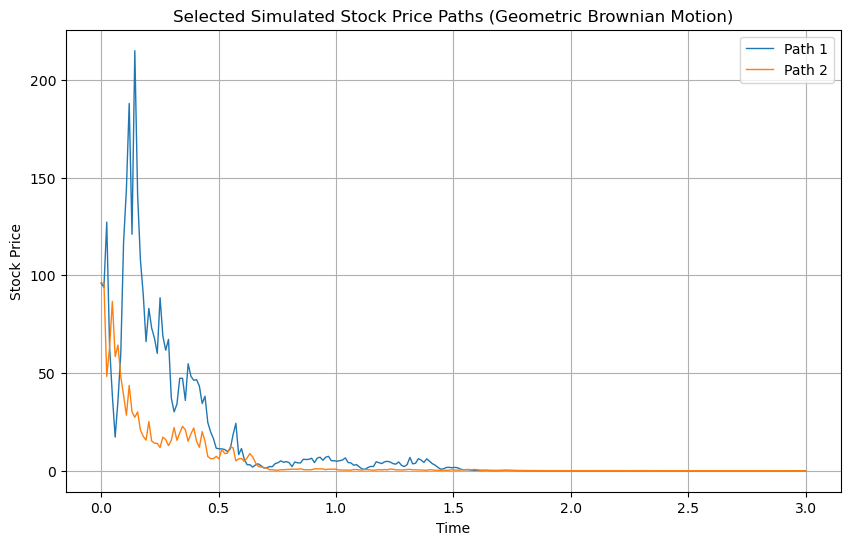

In [312]:
import matplotlib.pyplot as plt

# Assuming simulated_paths are stored in mc_option_pricing.S
simulated_paths = mc_option_pricing.S

# Select a few paths to plot and label
paths_to_label = [0, 1]  # Example: paths 1, 2, 3, 4

# Time points for x-axis
time_points = np.linspace(0, T, n)

# Plotting each path
plt.figure(figsize=(10, 6))
for i in paths_to_label:
    plt.plot(time_points, simulated_paths[i, :], lw=1, label=f'Path {i+1}')

plt.title('Selected Simulated Stock Price Paths (Geometric Brownian Motion)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


In [313]:
#mc_option_pricing.S[:,-1]

Now, the prices (averaging over the previously payoffs)

In [139]:
# Estimate prices by crude Monte Carlo
American_price_est = np.mean(American_payoffs)
Control_price_est = np.mean(Control_payoffs)
print(American_price_est)
print(Control_price_est)
print(len(American_payoffs), len(Control_payoffs))  # Both should be equal to n


107.90830828223848
90.97449043789429
10000 10000


Correlation Coefficient
-0.8767350423612389
SquaredCorr.
0.7686643345041634
Control variate price estimate
98.08411940775184
Variance ratio of payoffs (VAmerican/VControlVariate)
4.322722847870264


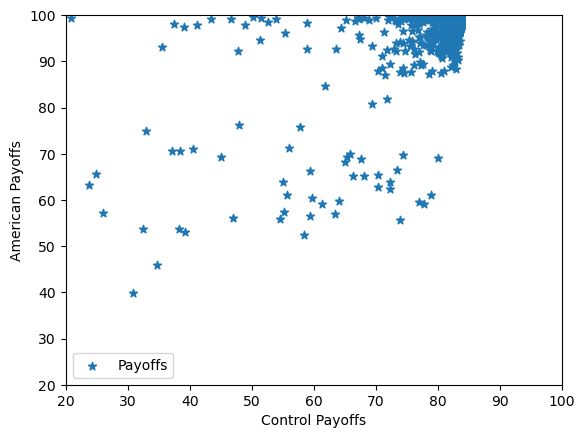

In [135]:
# Plots payoffs to show correlation
plt.scatter(Control_payoffs, American_payoffs, marker='*', label='Payoffs')
plt.xlabel('Control Payoffs')
plt.ylabel('American Payoffs')
plt.legend()

# Set axis limits
x_min, x_max = 20, 100  # Replace with your desired min and max for the x-axis
y_min, y_max = 20, 100  # Replace with your desired min and max for the y-axis

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Control mean (Calculated using Black-Scholes)
d1 = (1 / (σ * np.sqrt(T))) * (np.log(S0 / K) + (r + 0.5 * σ ** 2) * T)
d2 = d1 - σ * np.sqrt(T)
Control_mean = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)

# Calculates Y_i's
covariance = np.cov([American_payoffs, Control_payoffs], ddof=0)
thetaaa = -np.cov(American_payoffs,Control_payoffs)[0,1]/np.var(Control_payoffs) #OLS estimation of theta
Y = American_payoffs + thetaaa * (Control_payoffs - Control_mean)

# Prints correlation coefficient
#print('Correlation of payoffs')
rho = -np.corrcoef(American_payoffs, Control_payoffs)[0, 1]
print('Correlation Coefficient')
print(rho)
squaredcorr = rho**2
print("SquaredCorr.")
print(squaredcorr)

# Price est using control variate
print('Control variate price estimate')
print(np.mean(Y))

# Checks variances
print('Variance ratio of payoffs (VAmerican/VControlVariate)')
var_ratio = np.var(American_payoffs) / np.var(Y)
print(var_ratio)
#print(Y)


Running simulation for K=90, σ=1, T=1
Correlation Coefficient
-0.8529365119838399
SquaredCorr.
0.7275006934751591
Control variate price estimate
30.275869109628058
Variance ratio of payoffs (VAmerican/VControlVariate)
3.669734011620949
reduction factor (1-rh^2)^(-1): 3.6697341096126443


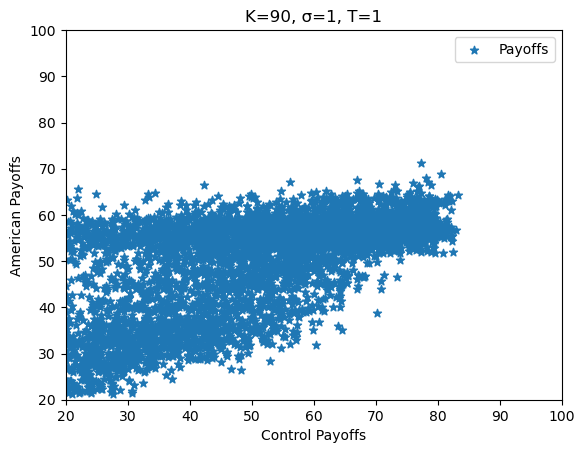

Running simulation for K=90, σ=1, T=2
Correlation Coefficient
-0.8652097173324345
SquaredCorr.
0.7485878549664712
Control variate price estimate
42.15618943658035
Variance ratio of payoffs (VAmerican/VControlVariate)
3.9775324699820964
reduction factor (1-rh^2)^(-1): 3.977532588438152


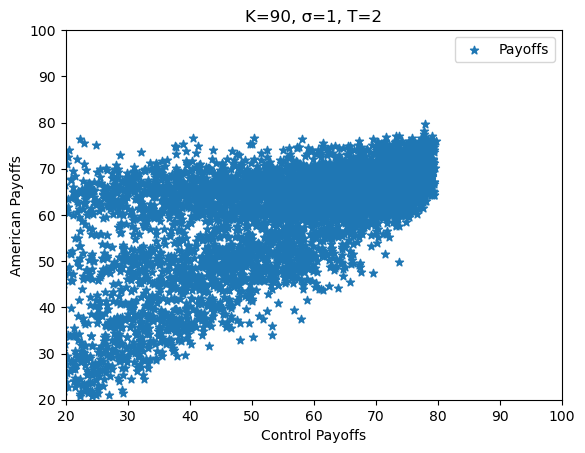

Running simulation for K=90, σ=1, T=3
Correlation Coefficient
-0.860654674403901
SquaredCorr.
0.7407264685732848
Control variate price estimate
50.061232239008575
Variance ratio of payoffs (VAmerican/VControlVariate)
3.8569304237198403
reduction factor (1-rh^2)^(-1): 3.856930533931708


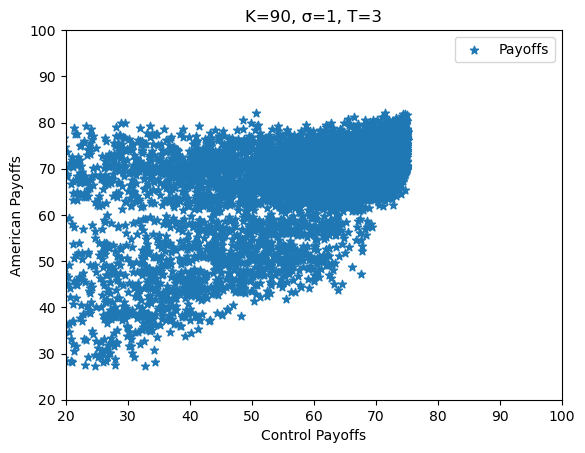

Running simulation for K=90, σ=2, T=1
Correlation Coefficient
-0.9089563140726615
SquaredCorr.
0.8262015808925589
Control variate price estimate
58.61511020212388
Variance ratio of payoffs (VAmerican/VControlVariate)
5.753791994128352
reduction factor (1-rh^2)^(-1): 5.753792267706453


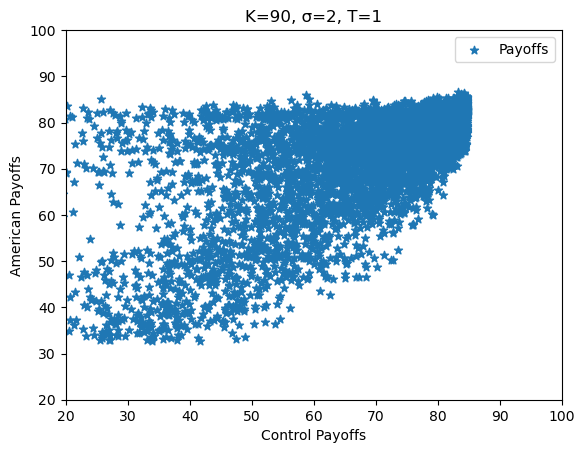

Running simulation for K=90, σ=2, T=2
Correlation Coefficient
-0.8931005787478113
SquaredCorr.
0.7976286437596756
Control variate price estimate
72.72976945277614
Variance ratio of payoffs (VAmerican/VControlVariate)
4.941410578829457
reduction factor (1-rh^2)^(-1): 4.941410773629734


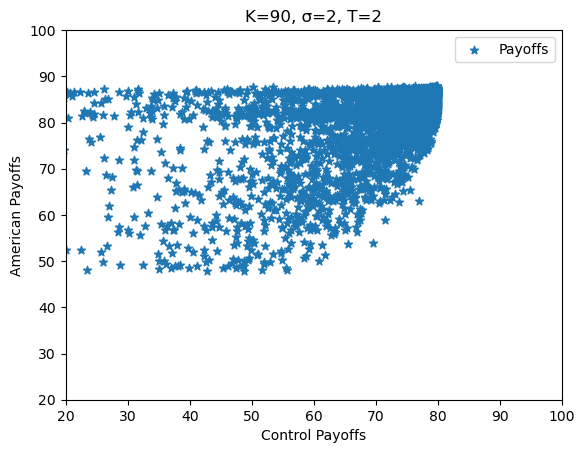

Running simulation for K=90, σ=2, T=3
Correlation Coefficient
-0.9066240126026056
SquaredCorr.
0.8219671002276496
Control variate price estimate
80.60682165540476
Variance ratio of payoffs (VAmerican/VControlVariate)
5.616939088786771
reduction factor (1-rh^2)^(-1): 5.616939348169322


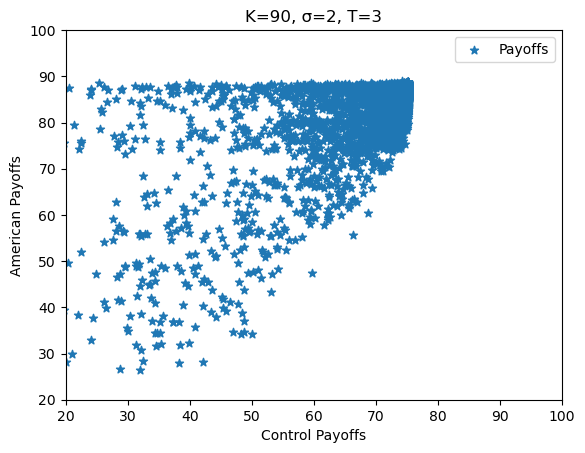

Running simulation for K=100, σ=1, T=1
Correlation Coefficient
-0.8446013689744714
SquaredCorr.
0.7133514724735511
Control variate price estimate
37.04805912274232
Variance ratio of payoffs (VAmerican/VControlVariate)
3.488592750635433
reduction factor (1-rh^2)^(-1): 3.4885928374696804


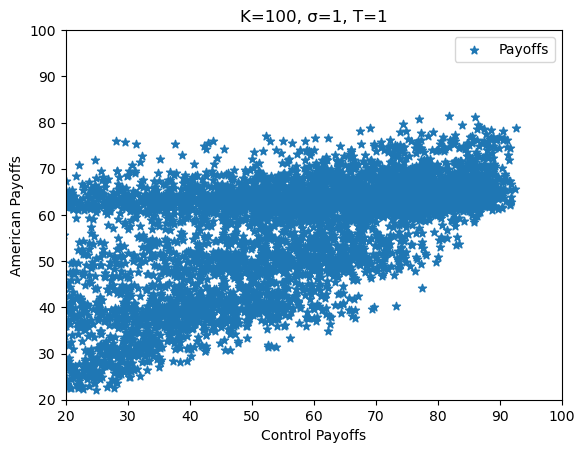

Running simulation for K=100, σ=1, T=2
Correlation Coefficient
-0.8592681355822229
SquaredCorr.
0.7383417288269495
Control variate price estimate
49.35462814432672
Variance ratio of payoffs (VAmerican/VControlVariate)
3.821778563671732
reduction factor (1-rh^2)^(-1): 3.8217786715354367


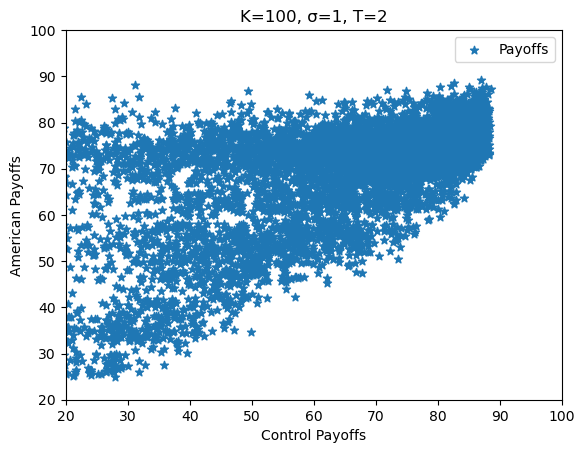

Running simulation for K=100, σ=1, T=3
Correlation Coefficient
-0.8541477387119272
SquaredCorr.
0.7295683595466986
Control variate price estimate
57.85976982247289
Variance ratio of payoffs (VAmerican/VControlVariate)
3.6977920606497334
reduction factor (1-rh^2)^(-1): 3.6977921604283646


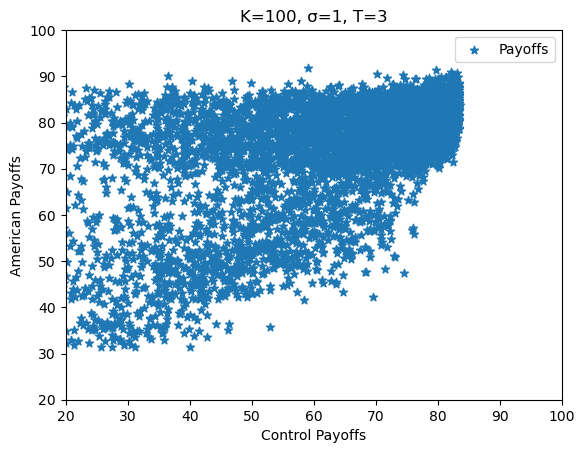

Running simulation for K=100, σ=2, T=1
Correlation Coefficient
-0.9053580625824106
SquaredCorr.
0.819673221482976
Control variate price estimate
66.70186171930385
Variance ratio of payoffs (VAmerican/VControlVariate)
5.545487823604788
reduction factor (1-rh^2)^(-1): 5.545488075724671


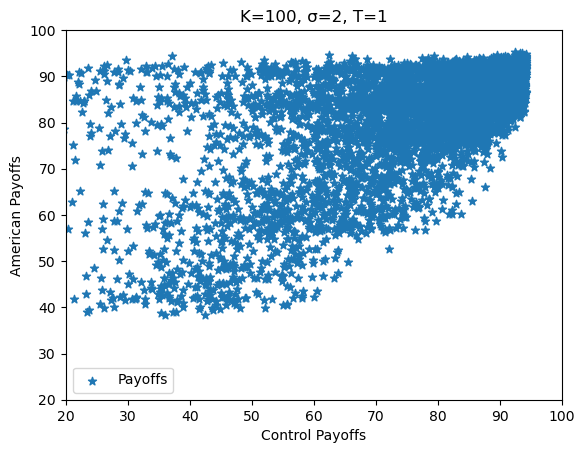

Running simulation for K=100, σ=2, T=2
Correlation Coefficient
-0.8882567797886312
SquaredCorr.
0.7890001068404687
Control variate price estimate
81.60019281076472
Variance ratio of payoffs (VAmerican/VControlVariate)
4.739338715413785
reduction factor (1-rh^2)^(-1): 4.739338892669141


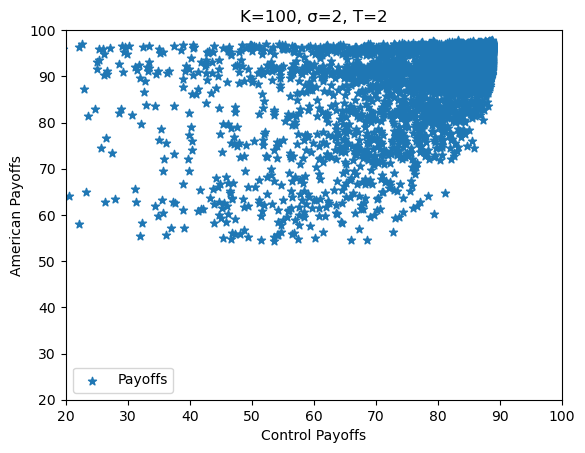

Running simulation for K=100, σ=2, T=3
Correlation Coefficient
-0.905465236657127
SquaredCorr.
0.8198672947945469
Control variate price estimate
90.02638910463105
Variance ratio of payoffs (VAmerican/VControlVariate)
5.55146248059567
reduction factor (1-rh^2)^(-1): 5.551462733318942


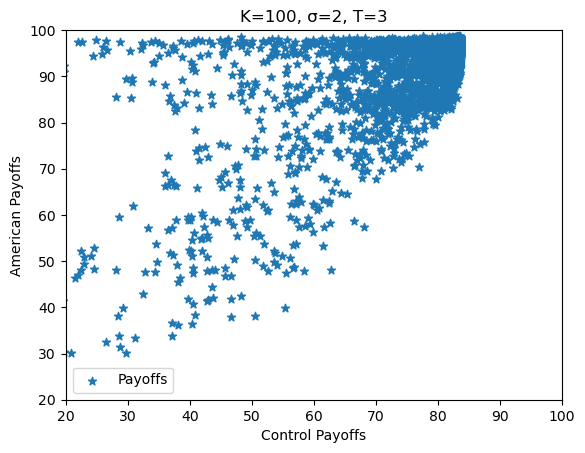

Running simulation for K=110, σ=1, T=1
Correlation Coefficient
-0.8419502730076361
SquaredCorr.
0.708880262217633
Control variate price estimate
44.01373516116356
Variance ratio of payoffs (VAmerican/VControlVariate)
3.4350126283521454
reduction factor (1-rh^2)^(-1): 3.4350127120118943


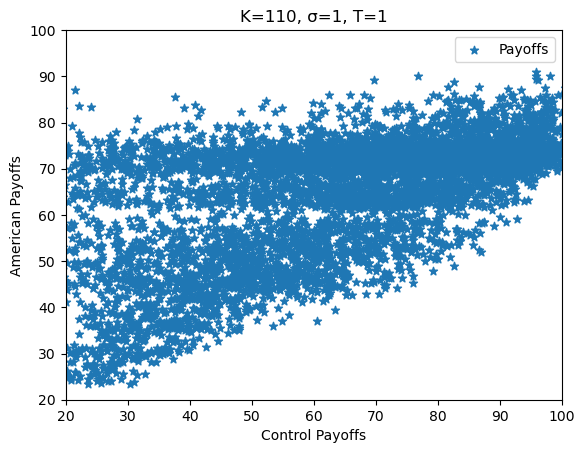

Running simulation for K=110, σ=1, T=2
Correlation Coefficient
-0.8525427189816621
SquaredCorr.
0.7268290876886453
Control variate price estimate
56.91774885509538
Variance ratio of payoffs (VAmerican/VControlVariate)
3.6607117680515553
reduction factor (1-rh^2)^(-1): 3.660711865472046


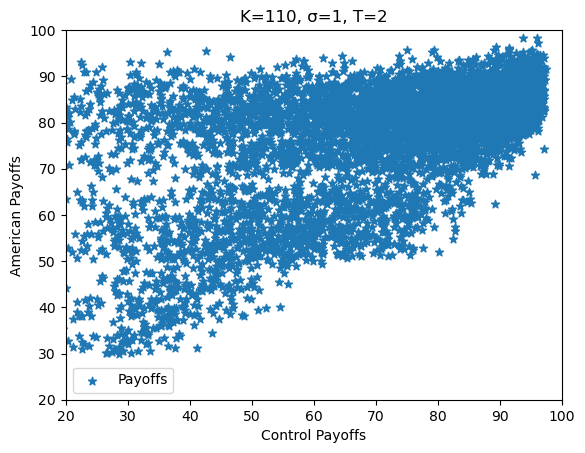

Running simulation for K=110, σ=1, T=3
Correlation Coefficient
-0.8506780882600472
SquaredCorr.
0.7236532098457686
Control variate price estimate
65.69317413449807
Variance ratio of payoffs (VAmerican/VControlVariate)
3.6186415382289767
reduction factor (1-rh^2)^(-1): 3.618641633007179


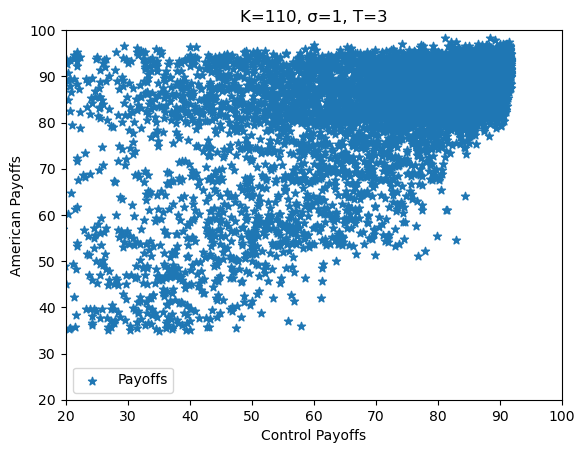

Running simulation for K=110, σ=2, T=1
Correlation Coefficient
-0.8987656239845192
SquaredCorr.
0.8077796468562821
Control variate price estimate
74.80617237121929
Variance ratio of payoffs (VAmerican/VControlVariate)
5.202362505391366
reduction factor (1-rh^2)^(-1): 5.202362724057257


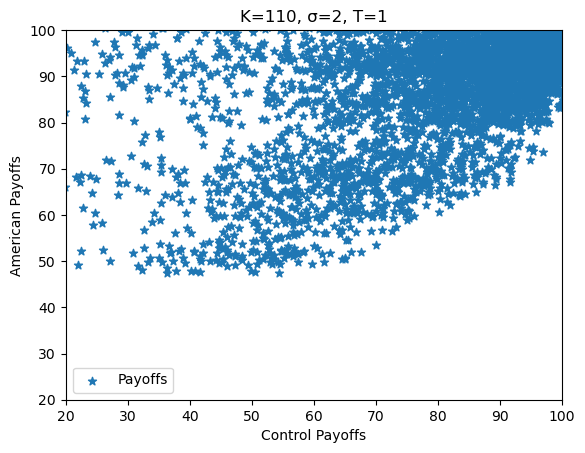

Running simulation for K=110, σ=2, T=2
Correlation Coefficient
-0.8803550320454494
SquaredCorr.
0.7750249824477442
Control variate price estimate
90.27708809651787
Variance ratio of payoffs (VAmerican/VControlVariate)
4.4449378265364885
reduction factor (1-rh^2)^(-1): 4.444937979692462


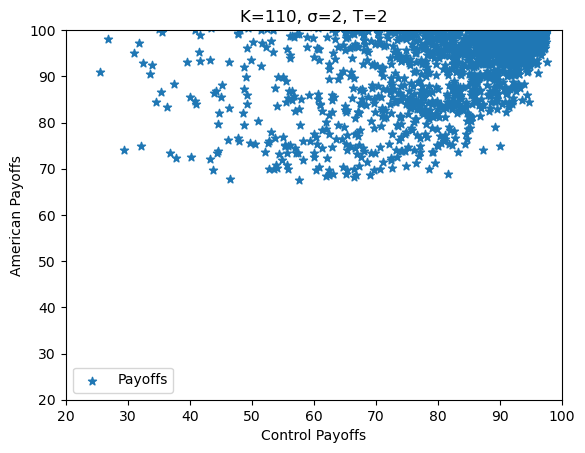

Running simulation for K=110, σ=2, T=3
Correlation Coefficient
-0.904701364664702
SquaredCorr.
0.818484559226174
Control variate price estimate
99.42903570296575
Variance ratio of payoffs (VAmerican/VControlVariate)
5.5091729421811895
reduction factor (1-rh^2)^(-1): 5.509173190649008


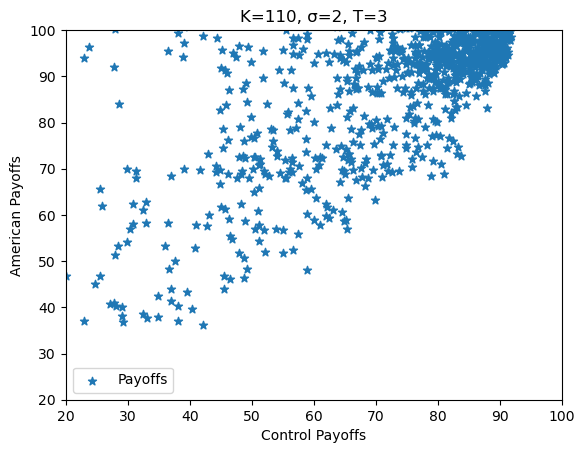

<Figure size 640x480 with 0 Axes>

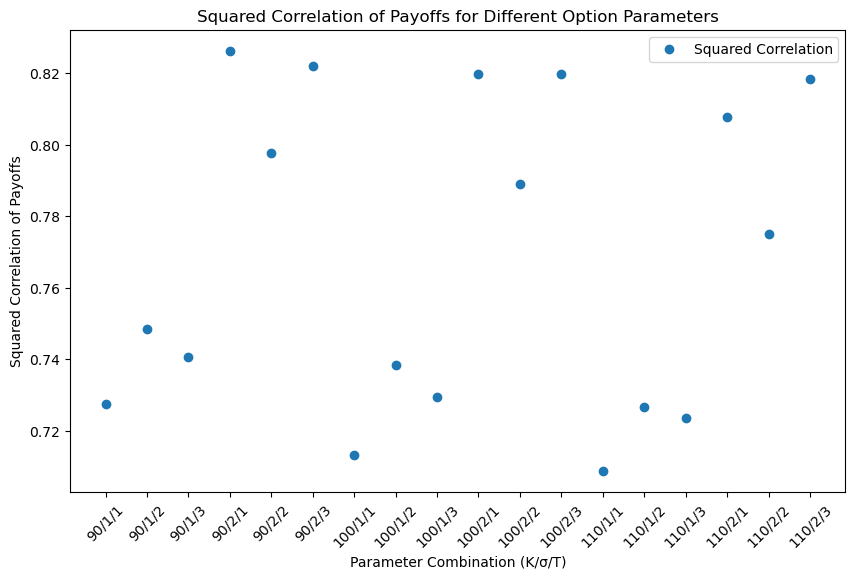

In [238]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Inputs
dim = 10000
n = 252
r = 0.06
S0 = 96
seed = 8
use_AV = True


# Define ranges for K, σ, and T
K_values = [90, 100, 110]
sigma_values = [1, 2]
T_values = [1, 2, 3]

# List to store squared correlations and parameter labels
squared_correlations = []
parameter_labels = []

# Loop over combinations of K, σ, and T
for K in K_values:
    for σ in sigma_values:
        for T in T_values:
            print(f"Running simulation for K={K}, σ={σ}, T={T}")

            # Initialize the Monte Carlo pricer
            mc_option_pricing = MonteCarloOptionPricing(r, S0, K, T, σ, dim, n, seed)

            # Simulation of GBM and LSM algorithm
            simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()
            mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')

            # Access and print the payoffs
            American_payoffs = mc_option_pricing.payoffs
            Control_payoffs = np.exp(-r * T) * np.maximum(K - mc_option_pricing.S[:, -1], 0)

            # Estimate prices by crude Monte Carlo
            American_price_est = np.mean(American_payoffs)
            Control_price_est = np.mean(Control_payoffs)

            # Calculate correlation and control variate price estimate
            # Control mean (Calculated using Black-Scholes)
            d1 = (1 / (σ * np.sqrt(T))) * (np.log(S0 / K) + (r + 0.5 * σ ** 2) * T)
            d2 = d1 - σ * np.sqrt(T)
            Control_mean = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)

            # Calculates Y_i's
            covariance = np.cov([American_payoffs, Control_payoffs], ddof=0)
            thetaaa = -np.cov(American_payoffs,Control_payoffs)[0,1]/np.var(Control_payoffs) #OLS estimation of theta
            Y = American_payoffs + thetaaa * (Control_payoffs - Control_mean)

            # Prints correlation coefficient
            #print('Correlation of payoffs')
            rho = -np.corrcoef(American_payoffs, Control_payoffs)[0, 1]
            print('Correlation Coefficient')
            print(rho)
            squaredcorr = rho**2
            print("SquaredCorr.")
            print(squaredcorr)

            # Price est using control variate
            print('Control variate price estimate')
            print(np.mean(Y))

            # Checks variances
            print('Variance ratio of payoffs (VAmerican/VControlVariate)')
            var_ratio = np.var(American_payoffs) / np.var(Y)
            print(var_ratio)
            #print(Y)
            reduction_factor = (1-squaredcorr)**(-1)
            print("reduction factor (1-rh^2)^(-1):", reduction_factor)
            # Plot payoffs for correlation
            plt.scatter(Control_payoffs, American_payoffs, marker='*', label='Payoffs')
            plt.xlabel('Control Payoffs')
            plt.ylabel('American Payoffs')
            plt.legend()
            plt.xlim(20, 100)  # Adjust as needed
            plt.ylim(20, 100)  # Adjust as needed
            plt.title(f'K={K}, σ={σ}, T={T}')
            plt.show()

            # Clear the plot for the next iteration
            plt.clf()
            
# Store the squared correlation and parameter label
            parameter_label = f"{K}/{σ}/{T}"
            squared_corr = (np.corrcoef(American_payoffs, Control_payoffs)[0, 1])**2
            squared_correlations.append(squared_corr)
            parameter_labels.append(parameter_label)

# Plot squared correlations against parameter combinations
plt.figure(figsize=(10, 6))
plt.plot(parameter_labels, squared_correlations, 'o', label='Squared Correlation')
plt.xlabel('Parameter Combination (K/σ/T)')
plt.ylabel('Squared Correlation of Payoffs')
plt.title('Squared Correlation of Payoffs for Different Option Parameters')
plt.xticks(rotation=45)
plt.legend()
plt.show()


# 2. Control Variates sampled at Exercise

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# Inputs
dim = 100000
n = 252
T = 3
σ = 2
K = 40
r = 0.06
S0 = 36
seed = 15
use_AV = True
#hans n = vores dim
#hans M = vores n
#hans sigma = vores σ

# Initialize the Monte Carlo pricer
mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=36., K=40., T=3., σ=2, dim=100000, n=252, seed=15, use_AV=True)

#Simualte paths
simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()

# Run the LSM algorithm to price the American option

#exercise_times
lsm_output = mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')
American_exercise_times = lsm_output[1]
American_exercise_times

# Access and print the payoffs
American_payoffs_ex = mc_option_pricing.payoffs
#print("Individual Payoffs:", American_payoffs_ex)


# Initialize variables for Control payoffs
Control_payoffs_ex = np.zeros(dim)

#print(American_exercise_times)

In [140]:
mc_option_pricing.S.shape

(100000, 252)

In [141]:
def get_stock_price_at_exercise(S, American_exercise_times, n, r, T, K, default_value=500):
    """
    Get the stock price at the specific exercise time for each path.

    Parameters:
    - S (np.array): 2D array of stock prices for different paths and timesteps.
    - American_exercise_times (np.array): Array of exercise times for each path.
    - n (int): The number of time steps.
    - r (float): Risk-free interest rate.
    - T (float): Time to maturity.
    - K (float): Strike price of the option.
    - default_value (float): Default stock price if the option was never exercised.

    Returns:
    - np.array: Array of payoffs at the specific exercise time for each path.
    """
    stock_prices_at_exercise = []  # List to store stock prices at exercise times
    Control_payoffs_ex = np.zeros(len(American_exercise_times))  # Initialize array for control payoffs

    for i, exercise_time in enumerate(American_exercise_times):
        if exercise_time == T:  # Option was never exercised
            stock_price = default_value
        else:
            column_index = int(exercise_time / (T / n))  # Convert time to column index
            stock_price = S[i, column_index]

        stock_prices_at_exercise.append(stock_price)
        Control_payoffs_ex[i] = np.exp(-r * exercise_time) * np.maximum(K - stock_price, 0)

    return Control_payoffs_ex

# Example usage
# Assuming mc_option_pricing.S, American_exercise_times, n, r, T, and K are defined
Control_payoff_ex = get_stock_price_at_exercise(mc_option_pricing.S, American_exercise_times, n, r, T, K)
print(Control_payoff_ex.shape)


(100000,)


In [142]:
American_payoffs_ex.shape

(100000,)

In [143]:
squared_corr_ex = (np.corrcoef(American_payoffs_ex, Control_payoff_ex)[0, 1])**2
print("squared corr.:", '{:.18f}'.format(squared_corr_ex))

squared corr.: 0.963519223524162971


(0.0, 50.0)

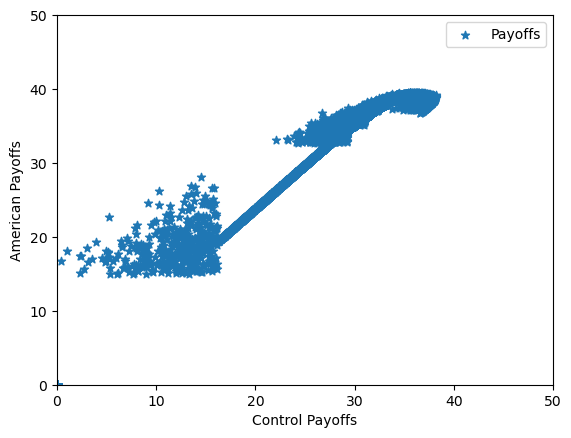

In [144]:
plt.scatter(Control_payoff_ex, American_payoffs_ex, marker='*', label='Payoffs')
plt.xlabel('Control Payoffs')
plt.ylabel('American Payoffs')
plt.legend()

# Set axis limits
x_min, x_max = 0, 50
y_min, y_max = 0, 50 
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

In [145]:
# CONTROL VARIATE ESTIMATION

# Control mean (Calculated using Black-Scholes)
d1 = (1 / (σ * np.sqrt(T))) * (np.log(S0 / K) + (r + 0.5 * σ ** 2) * T)
d2 = d1 - σ * np.sqrt(T)
Control_mean_ex = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)

# Calculates Y_i's
covariance_ex = np.cov([American_payoffs_ex, Control_payoff_ex], ddof=0)
thetaaa_ex = -np.cov(American_payoffs_ex,Control_payoff_ex)[0,1]/np.var(Control_payoff_ex) #OLS estimation of theta
Y_ex = American_payoffs_ex + thetaaa_ex * (Control_payoff_ex - Control_mean_ex)

# Prints correlation coefficient
#print('Correlation of payoffs')
rho_ex = -np.corrcoef(American_payoffs_ex, Control_payoff_ex)[0, 1]
print('Correlation Coefficient')
print(rho_ex)
squaredcorr_ex = rho_ex**2
print("SquaredCorr.")
print(squaredcorr_ex)

# Price est using control variate
print('Control variate price estimate')
print(np.mean(Y_ex))

# Checks variances
print('Variance ratio of payoffs (VAmerican/VControlVariate)')
var_ratio_ex = np.var(American_payoffs_ex) / np.var(Y_ex)
print(var_ratio_ex)
#print(Y)
reduction_factor = (1-squaredcorr_ex)**(-1)
print("reduction factor (1-rh^2)^(-1):", reduction_factor)

Correlation Coefficient
-0.9815901504824521
SquaredCorr.
0.963519223524163
Control variate price estimate
33.41033589895951
Variance ratio of payoffs (VAmerican/VControlVariate)
27.41169717210125
reduction factor (1-rh^2)^(-1): 27.41169724450213


squared corr.: 0.9551813075398848
Correlation Coefficient
-0.904701364664702
SquaredCorr.
0.9551813075398848
Control variate price estimate
31.335180782191625
Variance ratio of payoffs (VAmerican/VControlVariate)
22.312118961495315
reduction factor (1-rh^2)^(-1): 22.312119009047738


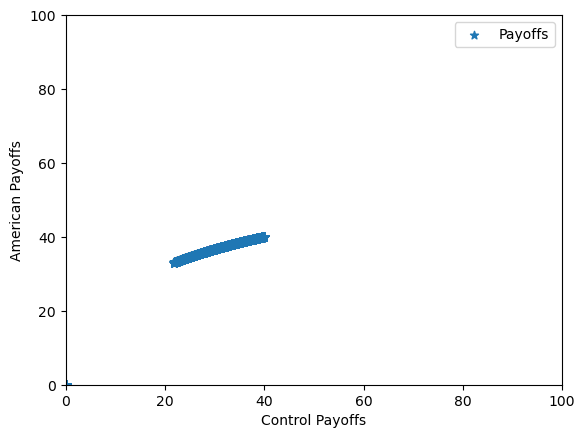

In [284]:
#mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=36., K=40., T=1., σ=0.2, dim=6, n=10, seed=15001, use_AV=True)

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# Inputs
dim = 100000
n = 5
T = 5
σ = 2
K = 40
r = 0.06
S0 = 40
seed = 1500
use_AV = True
#hans n = vores dim
#hans M = vores n
#hans sigma = vores σ

# Initialize the Monte Carlo pricer
mc_option_pricing = MonteCarloOptionPricing(r, S0, K, T, σ, dim, n, seed)

#Simualte paths
simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()

# Run the LSM algorithm to price the American option

#exercise_times
lsm_output = mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')

American_exercise_times = lsm_output[1]

#print(American_exercise_times)


# Access and print the payoffs
American_payoffs_ex = mc_option_pricing.payoffs
#print("Individual Payoffs:", American_payoffs_ex)


# Adjusting for zero-based indexing
adjusted_exercise_times = American_exercise_times

# Initialize variables for Control payoffs
Control_payoffs_ex = np.zeros(dim)

# Loop over each path
for i in range(dim):
    # Get the adjusted exercise time index for the ith path
    exercise_time_idx = int(adjusted_exercise_times[i])

    # Check to ensure the index is within bounds
    if exercise_time_idx < n:
        # Calculate the stock price at the exercise time
        stock_price_at_exercise = mc_option_pricing.S[i, exercise_time_idx]

        # Calculate the European put payoff at the exercise time
        Control_payoffs_ex[i] = np.exp(-r * stock_price_at_exercise) * np.maximum(K - stock_price_at_exercise, 0)
    else:
        # Handle cases where the exercise time index is out of bounds
        # For example, you might want to set the payoff to 0 or some other default value
        Control_payoffs_ex[i] = 0

#print("Control payoffs at American exercise times:", Control_payoffs_ex)


squared_corr_ex = (np.corrcoef(American_payoffs_ex, Control_payoffs_ex)[0, 1])**2
print("squared corr.:", squared_corr_ex)

plt.scatter(Control_payoffs_ex, American_payoffs_ex, marker='*', label='Payoffs')
plt.xlabel('Control Payoffs')
plt.ylabel('American Payoffs')
plt.legend()

# Set axis limits
x_min, x_max = 0, 100
y_min, y_max = 0, 100 
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)


# CONTROL VARIATE ESTIMATION

# Control mean (Calculated using Black-Scholes)
d1 = (1 / (σ * np.sqrt(T))) * (np.log(S0 / K) + (r + 0.5 * σ ** 2) * T)
d2 = d1 - σ * np.sqrt(T)
Control_mean_ex = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)

# Calculates Y_i's
covariance_ex = np.cov([American_payoffs_ex, Control_payoffs_ex], ddof=0)
thetaaa_ex = -np.cov(American_payoffs_ex,Control_payoffs_ex)[0,1]/np.var(Control_payoffs_ex) #OLS estimation of theta
Y_ex = American_payoffs_ex + thetaaa_ex * (Control_payoffs_ex - Control_mean_ex)

# Prints correlation coefficient
#print('Correlation of payoffs')
rho_ex = -np.corrcoef(American_payoffs_ex, Control_payoffs_ex)[0, 1]
print('Correlation Coefficient')
print(rho)
squaredcorr_ex = rho_ex**2
print("SquaredCorr.")
print(squaredcorr_ex)

# Price est using control variate
print('Control variate price estimate')
print(np.mean(Y_ex))

# Checks variances
print('Variance ratio of payoffs (VAmerican/VControlVariate)')
var_ratio_ex = np.var(American_payoffs_ex) / np.var(Y_ex)
print(var_ratio_ex)
#print(Y)
reduction_factor = (1-squaredcorr_ex)**(-1)
print("reduction factor (1-rh^2)^(-1):", reduction_factor)

The variance reduction factor,  i.e. the ration between the variance obtained by the standard LSM
approach and the variance of the respective control variate estimator. We find this by the inverse of (1-$\rho^2$), where $\rho^2$ is the  estimated squared correlation coefficient